In [17]:
## Standard Library
import os

## External Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from dipy.viz import regtools


CREATE DIRECTORIES

In [18]:
data_dir = '../Sample_data' # Directory with registered E11-30
output_dir = '../Sample_data' # Directory with final results

IMAGE DATASET CLASS

In [19]:
## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 data_dir,
                 transforms=None):
        
        self.input_dir = data_dir
        self.subjects = []
        for subdir in sorted(os.listdir(self.input_dir)):
            if int(subdir[-2:]) > 10:
                self.subjects.append(os.path.join(self.input_dir, subdir))
        self.transform = transforms
        

    def __len__(self):
        """
        
        """
        # return len(self.subjects)
        return len(self.subjects)

    def __getitem__(self,
                    idx):
        """
        
        """
        T1w = nib.load(os.path.join(f"{self.subjects[idx]}", "T1w.nii.gz"))
        T2w = nib.load(os.path.join(f"{self.subjects[idx]}", "T2w_align.nii.gz"))

        # Create tensors
        T1wdata = torch.tensor(T1w.get_fdata())
        T2wdata = torch.tensor(T2w.get_fdata())
        
        img = torch.cat([T1wdata[None], T2wdata[None]])
            
        # NORMALIZE
        mean = torch.tensor([136.4453,  65.2996])
        std = torch.tensor([286.8903, 141.4515])
        img = torch.cat([((img[0]-mean[0]) / std[0])[None], ((img[1]-mean[1]) / std[1])[None]], dim=0)
        img = nn.functional.interpolate(img[None], (145, 174, 145))
        img = img[0]

        # ## Use dictionary to output
        return img

UNET ARCHITECTURE

In [20]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   dilation=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine,
             stride=2,
             padding=1,
             output_padding=(0, 0, 0)):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose3d(ch_coarse, ch_fine, kernel_size=4, stride=stride, padding=padding, output_padding=output_padding, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, useBN=True):

        super(UNET, self).__init__()
        torch.manual_seed(42)
        # Downgrade stages
        dilation = 1
        stride = 1
        
        self.conv1 = add_conv_stage(2, 12, stride=stride, dilation=dilation, useBN=useBN) # for colorization training
        self.conv2 = add_conv_stage(12, 24, stride=stride, dilation=dilation, useBN=useBN)
        self.conv3 = add_conv_stage(24, 48, stride=stride, dilation=dilation, useBN=useBN)
        self.conv4 = add_conv_stage(48, 96, stride=stride, dilation=dilation, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(96, 48, dilation=dilation, useBN=useBN)
        self.conv2m = add_conv_stage(48,  24, dilation=dilation, useBN=useBN)
        self.conv1m = add_conv_stage(24,  12, dilation=dilation, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool3d(2)
        # Upsample layers
        self.upsample43 = upsample(96, 48, output_padding=(0, 1, 0))
        self.upsample32 = upsample(48,  24, output_padding=(0, 1, 0))
        self.upsample21 = upsample(24,  12, output_padding=(1, 0, 1))

        self.convFinal = nn.Sequential(nn.Conv3d(12, 2, kernel_size=1, stride=1, padding=0, bias=True),
                                       nn.ReLU())
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                if m.bias is not None:
                    m.bias.data.zero_()
        


    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))
        
        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv4_out = torch.tensor([])
        conv3m_out  = self.conv3m(conv4m_out_)
        conv4m_out_ = torch.tensor([])
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2_out = torch.tensor([])
        conv2m_out  = self.conv2m(conv3m_out_)
        conv3m_out_ = torch.tensor([])
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1_out = torch.tensor([])
        conv1m_out  = self.conv1m(conv2m_out_)
        conv2m_out_ = torch.tensor([])
        
        out = self.convFinal(conv1m_out)
        
        return out
        


In [21]:
def normalize(img):
    # img: [C, W, H, D]
    min0 = torch.min(img[0])
    max0 = torch.max(img[0])
    min1 = torch.min(img[1])
    max1 = torch.max(img[1])
    img[0] = (img[0] - min0) / (max0 - min0)
    img[1] = (img[1] - min1) / (max1 - min1)
    return img

In [22]:
def showResults(outputs, targets):
    # outputs, targets: [N, C, W, H, D]
    
    # SHOW RESULTS
    targets = targets.cpu()
    outputs = outputs.cpu()
    targets = normalize(targets[0])
    outputs = normalize(outputs[0])
    
    # SHOW RESULTS
    regtools.overlay_slices(targets[0].detach().numpy(), outputs[0].detach().numpy(), None, 2,
                                    "FA truth", "FA syn")
    regtools.overlay_slices(targets[1].detach().numpy(), outputs[1].detach().numpy(), None, 2,
                                    "ADC truth", "ADC syn")

In [23]:
test_dataset=ImageDataset(data_dir=data_dir)
test_dataloader = DataLoader(test_dataset, batch_size=1)

EVALUATE

Subject 11
Subject 13
Subject 15
Subject 17
Subject 19


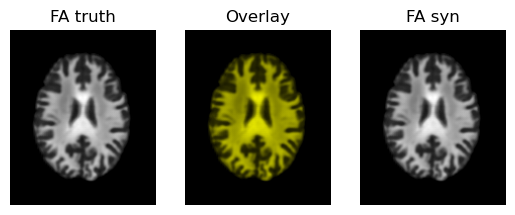

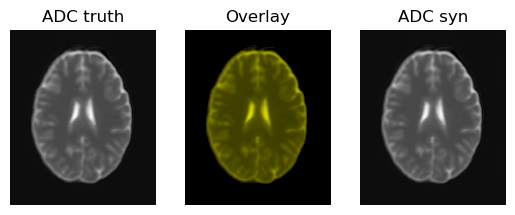

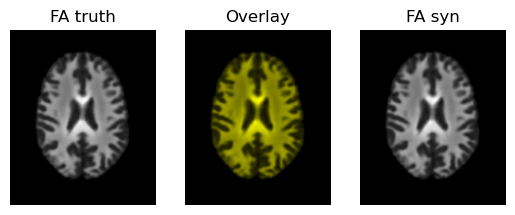

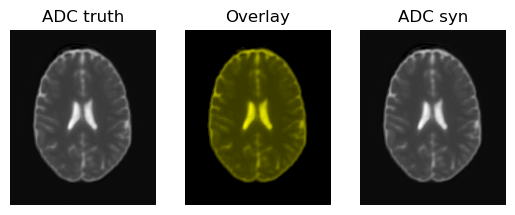

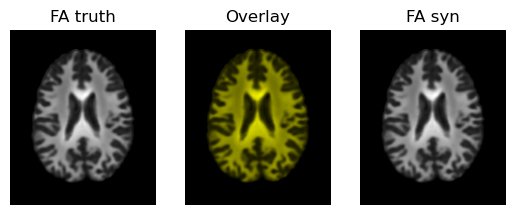

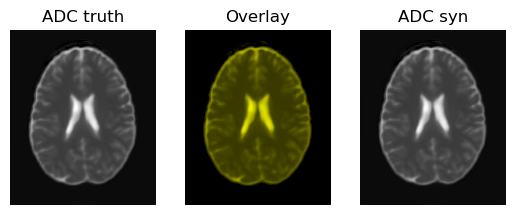

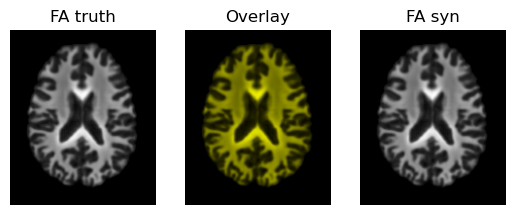

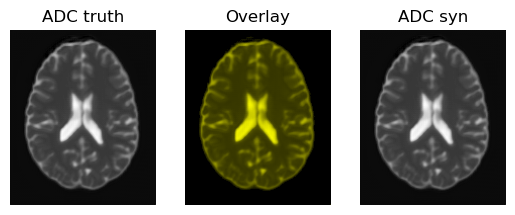

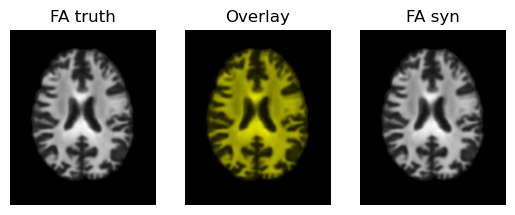

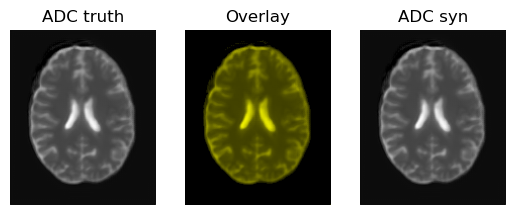

In [24]:
model = UNET()

if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    use_gpu = True
    model = nn.DataParallel(model)
else:
    use_gpu = False
model = model.to(device)
model.load_state_dict(torch.load('UNET_12ch_lr1e3.pt'))
model.eval()

with torch.no_grad():
    i=0
    for img in test_dataloader:
        if use_gpu:
            img = img.to(device)
        img = img.float()
        out = model(img) 
        if i % 2 == 0: # plot every other one
            print(f'Subject {i+11}')
            showResults(out, out)
        img = img.cpu()
        output_loc = os.path.join(output_dir, f'0{i+11}')
        if not os.path.exists(output_loc):
            os.mkdir(output_loc)
        FAout = nib.Nifti1Image(img[0, 0].detach().numpy(), affine=None)
        ADCout = nib.Nifti1Image(img[0, 1].detach().numpy(), affine=None)
        nib.save(FAout, os.path.join(output_loc, 'FA_syn.nii.gz'))
        nib.save(ADCout, os.path.join(output_loc, 'ADC_syn.nii.gz'))
        i = i + 1
